In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics.pairwise import cosine_similarity
from window_ops.rolling import rolling_mean, rolling_max, rolling_min

import sys
import os
sys.path.append(os.path.abspath("../"))

from scripts.evaluate import evaluate_forecasts
from scripts.visualization import *

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
df_brl = pd.read_parquet('../data/all_comm/comm_brl.parquet')
df_usd = pd.read_parquet('../data/all_comm/comm_usd.parquet')

In [ ]:
series_data_brl = {}
series_data_usd = {}

for uid in df_brl['unique_id'].unique():
    series = df_brl[df_brl['unique_id'] == uid]
    y_series = series['y'].values
    last_6_lags = y_series[-6:]
    
    series_data_brl[uid] = {
        'series': series,
        'y_series': y_series,
        'v_curr_lags': last_6_lags
    }

for uid in df_usd['unique_id'].unique():
    series = df_usd[df_usd['unique_id'] == uid]
    y_series = series['y'].values
    last_6_lags = y_series[-6:]
    
    series_data_usd[uid] = {
        'series': series,
        'y_series': y_series,
        'v_curr_lags': last_6_lags
    }

# series_data_brl['SOJA']['series']: DataFrame da série de soja brl
# series_data_brl['SOJA']['y_series']: array dos valores y da soja brl
# series_data_brl['SOJA']['v_curr_lags']: últimos 6 valores de y da soja brl

# series_data_usd['SOJA']['series']: DataFrame da série de soja usd
# series_data_usd['SOJA']['y_series']: array dos valores y da soja usd
# series_data_usd['SOJA']['v_curr_lags']: últimos 6 valores de y da soja usd

In [5]:
# função que extrai janelas (região de competência)
def extract_lag_windows(series, window_size=6):
    windows = []
    targets = []
    for i in range(window_size, len(series)-1):
        windows.append(series[i-window_size:i])
        targets.append(series[i])  # valor seguinte real
    return np.array(windows), np.array(targets)

In [6]:
# avalia modelos na região de competência
from sklearn.metrics import mean_squared_error

def evaluate_models(models, X, y):
    scores = []
    for model in models:
        model.fit(X, y)
        y_pred = model.predict(X)
        score = mean_squared_error(y, y_pred)
        scores.append(score)
    return np.array(scores)

In [7]:
models = [
    LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbose=-1
    ),
    XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbosity=0
    ),
    KNeighborsRegressor(
        n_neighbors=5,
        weights='distance'
    ),
    MLPRegressor(
        hidden_layer_sizes=(50, 25),
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ),
    RandomForestRegressor(
        n_estimators=100,
        max_depth=3,
        random_state=42
    )
]

## BRL

Previsão para o próximo ponto: 141.439


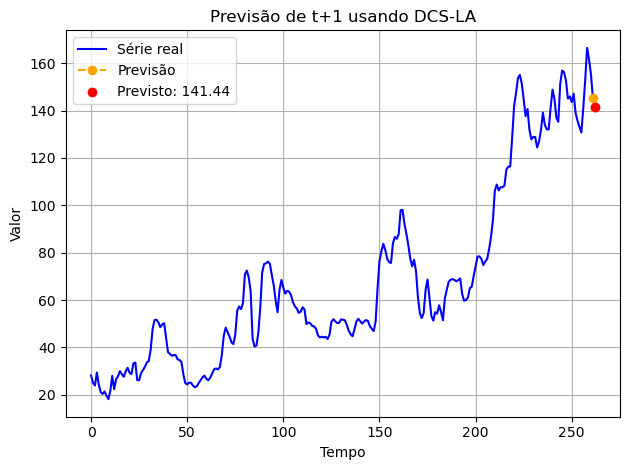

Previsão para o próximo ponto: 383.720


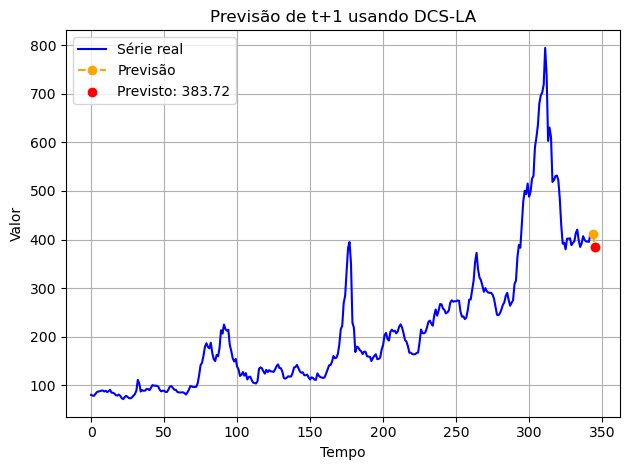

Previsão para o próximo ponto: 998.715


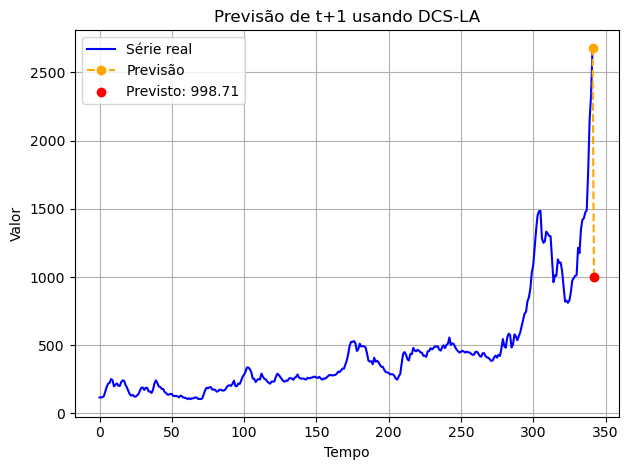

Previsão para o próximo ponto: 38.041


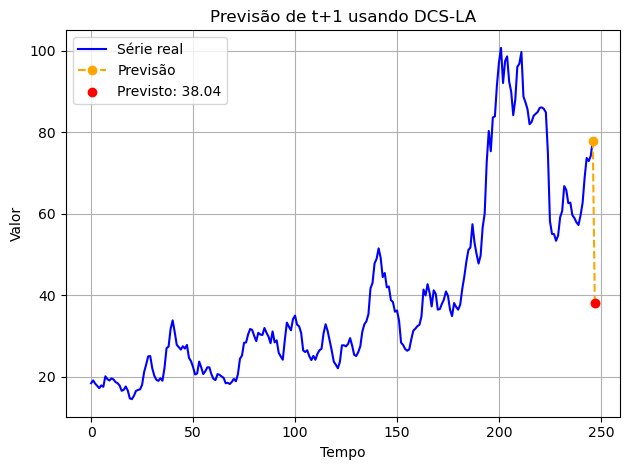

Previsão para o próximo ponto: 117.513


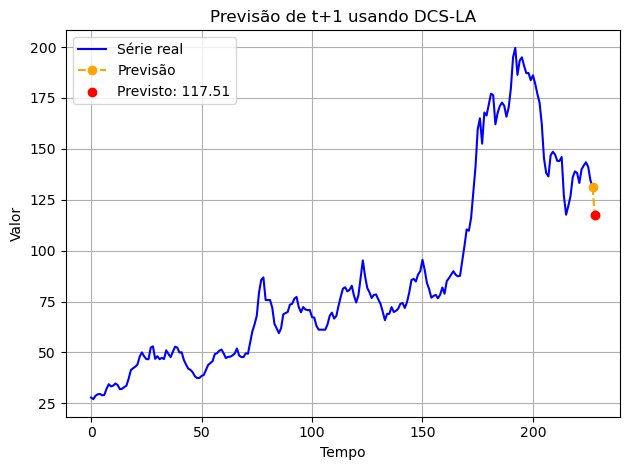

In [ ]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

for id in df_brl['unique_id'].unique():
    windows, targets = extract_lag_windows(series_data_brl[id]['y_series'], window_size=6)
    
    # similaridade entre a janela atual e as janelas passadas
    sims = cosine_similarity([series_data_brl[id]['v_curr_lags']], windows)[0]
    
    # seleciona top 10 janelas mais parecidas
    top_k_idx = sims.argsort()[-10:]
    competence_X = windows[top_k_idx]
    competence_y = targets[top_k_idx]

    errors = evaluate_models(models, competence_X, competence_y)
    best_model = models[np.argmin(errors)]

    # previsão com o melhor modelo
    y_next = best_model.predict([series_data_brl[id]['v_curr_lags']])[0]
    print(f"Previsão para o próximo ponto: {y_next:.3f}")

    y_full = np.append(series_data_brl[id]['y_series'], y_next)

    x = np.arange(len(y_full))

    plt.plot(x[:-1], series_data_brl[id]['y_series'], label='Série real', color='blue')

    plt.plot(x[-2:], y_full[-2:], '--o', label='Previsão', color='orange')

    plt.scatter(x[-1], y_next, color='red', zorder=5, label=f'Previsto: {y_next:.2f}')

    plt.title('Previsão de t+1 usando DCS-LA')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## USD

Previsão para o próximo ponto: 25.056


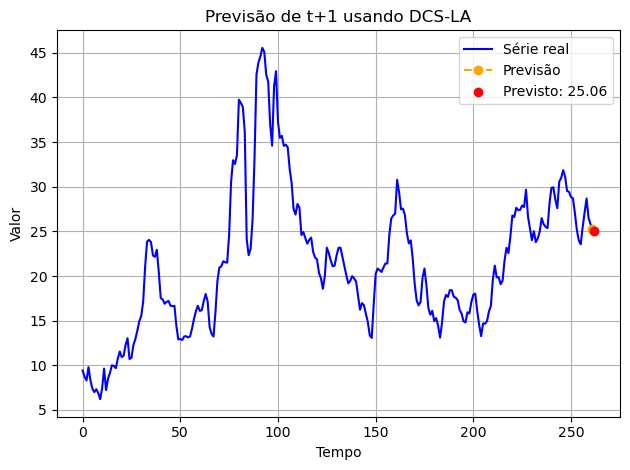

Previsão para o próximo ponto: 76.260


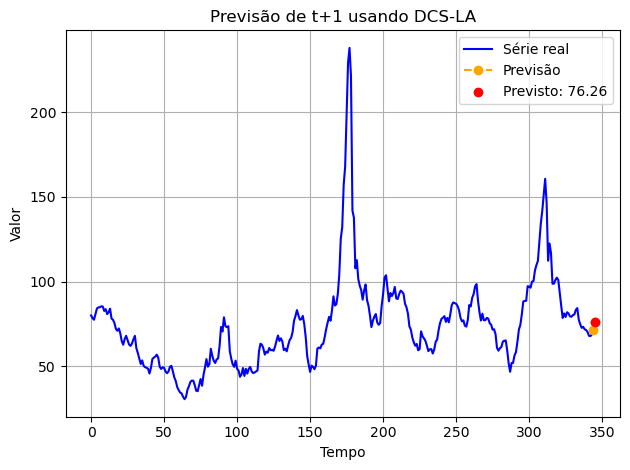

Previsão para o próximo ponto: 269.911


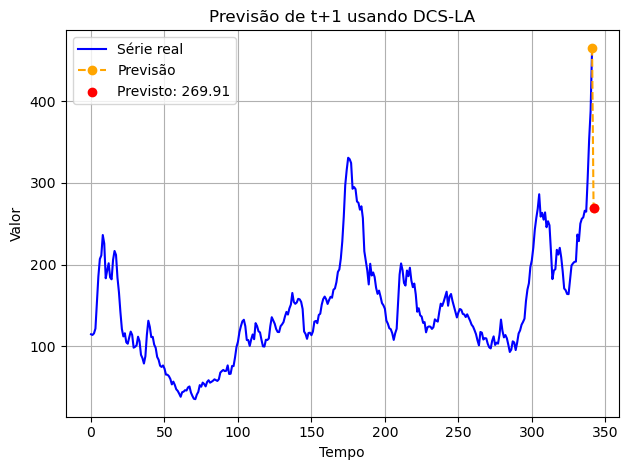

Previsão para o próximo ponto: 13.080


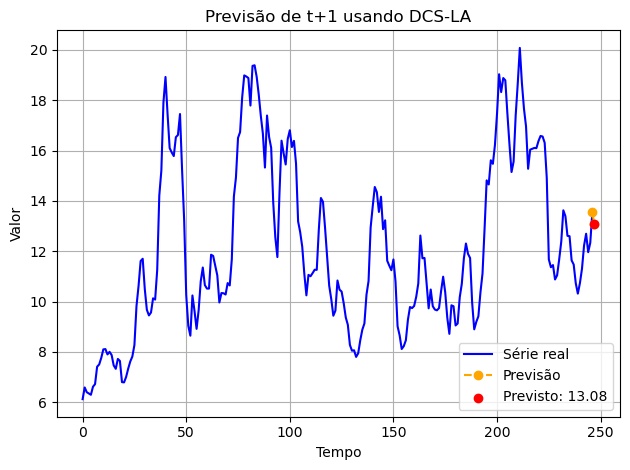

Previsão para o próximo ponto: 21.071


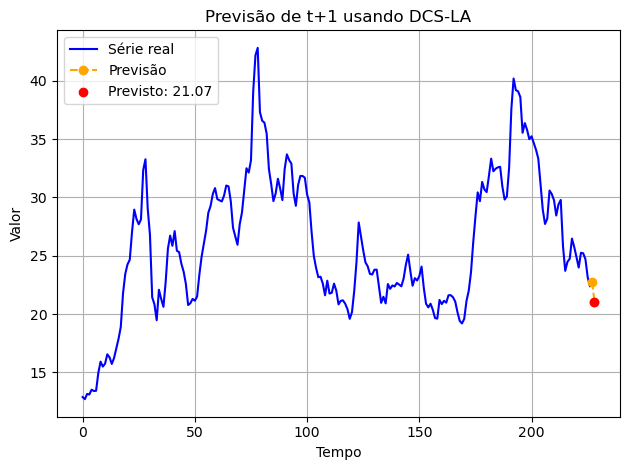

In [ ]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

for id in df_usd['unique_id'].unique():
    windows, targets = extract_lag_windows(series_data_usd[id]['y_series'], window_size=6)
    
    # similaridade entre a janela atual e as janelas passadas
    sims = cosine_similarity([series_data_usd[id]['v_curr_lags']], windows)[0]
    
    # seleciona top 10 janelas mais parecidas
    top_k_idx = sims.argsort()[-10:]
    competence_X = windows[top_k_idx]
    competence_y = targets[top_k_idx]

    errors = evaluate_models(models, competence_X, competence_y)
    best_model = models[np.argmin(errors)]

    # previsão com o melhor modelo
    y_next = best_model.predict([series_data_usd[id]['v_curr_lags']])[0]
    print(f"Previsão para o próximo ponto: {y_next:.3f}")

    y_full = np.append(series_data_usd[id]['y_series'], y_next)

    x = np.arange(len(y_full))

    plt.plot(x[:-1], series_data_usd[id]['y_series'], label='Série real', color='blue')

    plt.plot(x[-2:], y_full[-2:], '--o', label='Previsão', color='orange')

    plt.scatter(x[-1], y_next, color='red', zorder=5, label=f'Previsto: {y_next:.2f}')

    plt.title('Previsão de t+1 usando DCS-LA')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()